In [54]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sbcbinaryformat import Streamer

sys.path.append("../LAr10Ana")
from GetEvent import GetEvent
from ana.SiPMPulses import SiPMPulses

In [129]:
def get_area(trig, ch, traces):
    trace = traces[trig, ch]
    baseline = np.mean(trace[:40])
    # calculate area
    min_ind = np.argmin(trace[:-20])
    dt = 8e-9
    area = -np.sum(trace[min_ind-15:min_ind+30] - baseline) * dt
    return area  # V*s

def get_bl(ind, ch, traces):
    return np.mean(traces[ind, ch, :40])

def get_led(ind, traces):
    trigger = traces['traces'][ind,1] * traces['v_scale'][ind,1] + traces['v_offset'][ind,1]
    # if triggered, more than 10 points will be below -0.1
    return np.sum(trigger[:-40] < -0.1) >10

In [116]:
def gen_hist(runs):
    all_area = np.array([])
    livetime = 0
    for run in runs:
        evs = np.array(os.listdir(os.path.join(raw_directory, run)))
        dirfilter = [os.path.isdir(os.path.join(raw_directory, run, i)) for i in evs]
        evs = evs[dirfilter]
        
        for ev in evs:            
            pmttraces = rb.ReadBlock(os.path.join(raw_directory, run, str(ev), "PMTtraces.bin"))
            tstart = np.mean(pmttraces['t0_sec'][0]++pmttraces['t0_frac'][0])
            tend = np.mean(pmttraces['t0_sec'][-1]++pmttraces['t0_frac'][-1])
            livetime += tend - tstart
            
            all_bl = np.array([get_bl(ind, pmttraces) for ind in range(len(pmttraces['traces']))])
            
            baseline_lower_cut = (np.mean(all_bl)-np.std(all_bl) <= all_bl)
            baseline_upper_cut = (all_bl <= 0)
            baseline_cut = [baseline_lower_cut[i] and baseline_upper_cut[i] for i in range(len(baseline_lower_cut))]
            
            ev_area = np.array([area(ind, pmttraces) for ind in range(len(pmttraces['traces']))])[baseline_cut]
            all_area = np.append(all_area, ev_area)
    print("done: ", livetime)
    return all_area, livetime
    
def plot_hist(all_area, livetime):
    endpoint = 4e-7
    binwidth = (endpoint+1e-9)/100
    p = np.histogram(-all_area, bins=100, range=(-1e-9, endpoint))
    x = p[1][:-1]
    y = p[0]/livetime/binwidth
    plt.step(x,y)
    plt.xlabel("V*second")
    plt.ylabel("rate (Hz/V/s)")
    #plt.ylim(15, 3e5)
    plt.yscale("log")

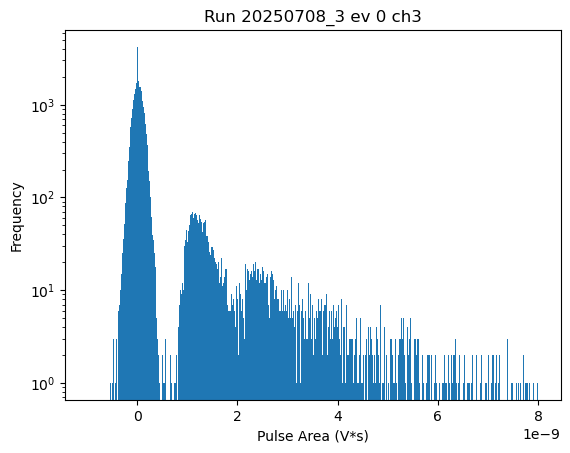

In [140]:
ch = 3
areas = [get_area(trig, ch, traces) for trig in range(traces.shape[0])]
plt.hist(areas, bins=500, range=(-1e-9,8e-9))
plt.title(f"Run {run} ev {ev} ch{ch}")
plt.xlabel("Pulse Area (V*s)")
plt.ylabel("Frequency")
plt.yscale("log")

In [114]:
trace = smoothed[1,27]
bl = np.mean(trace[:40])
min_ind = np.argmin(trace[:-20])
dt = 8e-9
area = np.sum(trace[min_ind-15:min_ind+30] - bl) * dt
area

np.float64(-3.0160156250000086e-09)

In [3]:
data_dir = "/home/zhiheng/data/sbc/"
run = "20250708_3"
ev = 0
path = os.path.join(data_dir, run)
data = GetEvent(path, ev, strictMode=False)
scint = data["scintillation"]

In [105]:
traces = scint["Waveforms"] * 2. / 2**12
scint_t = [0.008*i for i in range(traces.shape[2])]  # 8ns per step

window_size = 5
kernel = np.ones(window_size) / window_size
smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis=2, arr=traces)

In [5]:
pulses = SiPMPulses(data)

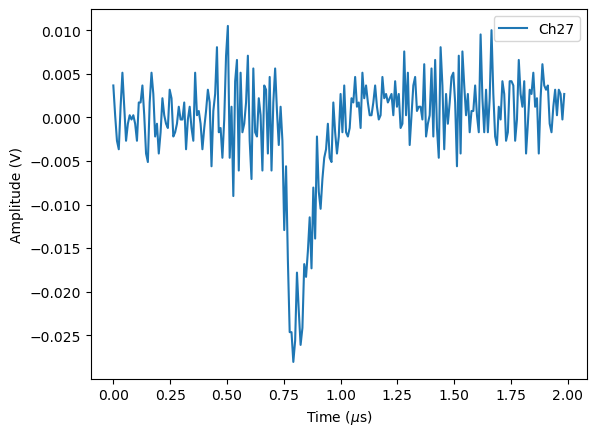

In [48]:
ind = 1
for ch in range(traces.shape[1]):
    if ch!=27:
        continue
    plt.plot(scint_t, traces[ind,ch], label=f"Ch{ch}")
plt.xlabel(r"Time ($\mu$s)")
plt.ylabel(r"Amplitude (V)")
plt.legend()
plt.show()

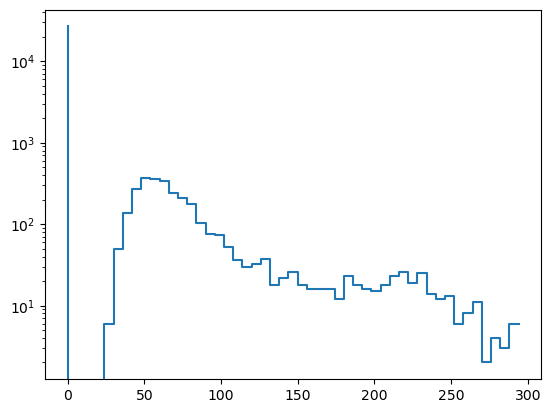

In [49]:
ch = 27
hist = np.histogram(pulses["hit_area"][ch], range=(0,300), bins=50)
plt.step(hist[1][:-1], hist[0])
plt.yscale("log")

In [53]:
pulses["hit_area"][1][27]

np.float64(0.0)

In [55]:
print(data)

{'acoustics': {'loaded': False, 'sample_rate': 1000000}, 'scintillation': {'loaded': True, 'EventCounter': array([    1,     2,     3, ..., 30111, 30112, 30113], dtype=uint32), 'TriggerSource': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), 'GroupMask': array([15, 15, 15, ..., 15, 15, 15], dtype=uint8), 'TriggerMask': array([2147483647, 2147483647, 2147483647, ..., 2147483647, 2147483647,
       2147483647], dtype=uint32), 'AcquisitionMask': array([4294967295, 4294967295, 4294967295, ..., 4294967295, 4294967295,
       4294967295], dtype=uint32), 'TriggerTimeTag': array([   1104647,    2354639,    3604631, ..., 3278640029, 3279890021,
       3281140015], dtype=uint32), 'Waveforms': array([[[2113, 2101, 2118, ..., 2114, 2112, 2116],
        [2107, 2103, 2119, ..., 2112, 2111, 2114],
        [2113, 2114, 2109, ..., 2109, 2111, 2122],
        ...,
        [2112, 2111, 2111, ..., 2111, 2106, 2112],
        [2106, 2115, 2106, ..., 2118, 2111, 2115],
        [2113, 2113, 2112, ..., 2112, 2112,